<a href="https://colab.research.google.com/github/prabal5ghosh/research-project-on-physics-informed-machine-learning-on-transcriptomics-data/blob/main/VAE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 3.7844674587249756
Epoch 5, Loss: 1.228754997253418
Epoch 10, Loss: 1.6013715267181396
Epoch 15, Loss: 1.282090663909912
Epoch 20, Loss: 1.3024901151657104
Epoch 25, Loss: 1.2118645906448364
Epoch 30, Loss: 1.1571018695831299
Epoch 35, Loss: 1.1696759462356567
Epoch 40, Loss: 1.1700340509414673
Epoch 45, Loss: 1.3201255798339844


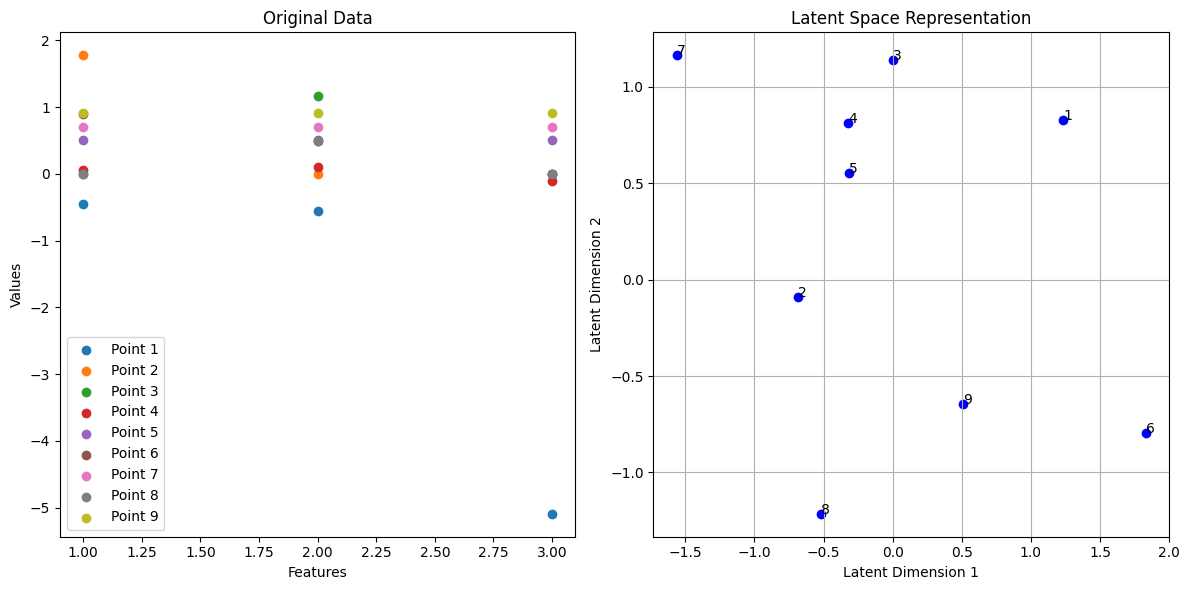

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define the VAE components: Encoder, Decoder, and VAE
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2_mean = nn.Linear(32, latent_dim)  # Mean of latent space
        self.fc2_logvar = nn.Linear(32, latent_dim)  # Log-variance of latent space

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, output_dim)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        return self.fc2(z)


class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mean, logvar, z


# Loss function
def vae_loss(reconstructed, x, mean, logvar):
    recon_loss = nn.MSELoss()(reconstructed, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + kl_div


# Prepare the dataset
data = np.array([
    [-0.44796003, -0.560154646, -5.091964284],
    [1.778358524, 0, 0],
    [0, 1.175149691, 0],
    [0.055374646, 0.098434984, -0.101756864],
    [0.505, 0.505, 0.505],
    [0.9, 0.5, 0],
    [0.7, 0.7, 0.7],
    [0, 0.5, 0],
    [0.906000416, 0.906000416, 0.906000416]
], dtype=np.float32)

data_tensor = torch.tensor(data)
input_dim = data.shape[1]
latent_dim = 2  # Dimensionality of the latent space

# Initialize the VAE
vae = VAE(input_dim=input_dim, latent_dim=latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)

# Train the VAE
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    reconstructed, mean, logvar, _ = vae(data_tensor)
    loss = vae_loss(reconstructed, data_tensor, mean, logvar)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Extract latent vectors
with torch.no_grad():
    _, _, _, latent_vectors = vae(data_tensor)

latent_vectors = latent_vectors.numpy()

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(data.shape[0]):
    plt.scatter(range(1, input_dim + 1), data[i], label=f"Point {i+1}")
plt.title("Original Data")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend()

# Plot the latent vectors
plt.subplot(1, 2, 2)
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], color="blue")
for i, txt in enumerate(range(1, data.shape[0] + 1)):
    plt.annotate(txt, (latent_vectors[i, 0], latent_vectors[i, 1]))
plt.title("Latent Space Representation")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid()
plt.tight_layout()
plt.show()
